In [1]:
import os                              
import numpy as np
from numpy import number                    
import pandas as pd                     
import matplotlib.pyplot as plt  
import math
from typing import List
from azure.quantum.optimization import Problem, ProblemType, Term
from azure.quantum.optimization import ParallelTempering
from azure.quantum.optimization import Term, SlcTerm

Data Preprocessing

In [2]:
stocks = [stock.split('.')[0] for stock in sorted(os.listdir("Datasets/Bombay Stock Exchange Top 50 (last 20 years data)"))]
stocks = stocks[1:]

print(stocks)

['ADANIENT', 'ADANIGREEN', 'ADANIPORTS', 'ADANIPOWER', 'ADANITRANS', 'ASIANPAINT', 'ATGL', 'AXISBANK', 'BAJAJ-AUTO*', 'BAJAJFINSV', 'BAJFINANCE', 'BHARTIARTL', 'BRITANNIA', 'COALINDIA', 'DABUR', 'DIVISLAB', 'DMART', 'HCLTECH', 'HDFC', 'HDFCBANK', 'HDFCLIFE', 'HINDUNILVR', 'HINDZINC', 'ICICIBANK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL', 'KOTAKBANK', 'LT', 'M&M', 'MARUTI', 'NESTLEIND', 'NTPC', 'ONGC', 'PIDILITIND', 'POWERGRID', 'RELIANCE', 'SBILIFE', 'SBIN', 'SIEMENS', 'SUNPHARMA', 'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO', 'WIPRO']


In [3]:
dates = pd.date_range('2020-06-27', '2022-06-27') 
data = pd.DataFrame({'Time': dates})


In [4]:
for stock in stocks:
    prices = pd.read_csv("Datasets/Bombay Stock Exchange Top 50 (last 20 years data)/"+stock+".csv", usecols=['Date', 'WAP'])
    #print(prices)
    prices['Date'] = pd.to_datetime(prices['Date'], dayfirst = True)  
    #print(prices)
    prices.rename(                                                            
        columns={"Date": "Time", "WAP": stock},
        inplace=True
    )
    data = pd.merge(data,prices)
print(data)

          Time     ADANIENT   ADANIGREEN  ADANIPORTS  ADANIPOWER   ADANITRANS  \
0   2020-06-29   159.687942   377.549942  341.654664   36.403273   272.677199   
1   2020-06-30   159.160562   358.699993  346.728165   36.221707   262.479721   
2   2020-07-01   157.467809   340.799950  344.546232   35.876913   264.566015   
3   2020-07-02   158.572490   340.665187  347.204457   35.958567   267.357540   
4   2020-07-03   161.300691   375.649950  361.634482   35.888083   263.796821   
..         ...          ...          ...         ...         ...          ...   
494 2022-06-21  2135.639904  1781.609758  682.067737  247.598922  2164.276059   
495 2022-06-22  2099.523327  1760.070866  672.045492  249.228760  2140.302787   
496 2022-06-23  2108.266003  1781.589066  675.405151  253.533681  2108.878187   
497 2022-06-24  2133.605969  1851.278832  683.102882  261.148474  2129.006294   
498 2022-06-27  2188.648927  1906.666153  692.876943  273.437845  2149.214171   

      ASIANPAINT         AT

In [5]:
cp = data .drop(['Time'], axis=1).tail(1).to_numpy()
cp = cp[0]
cp

array([ 2188.64892669,  1906.66615311,   692.87694294,   273.437845  ,
        2149.21417057,  2788.86886379,  2295.53442281,   638.86063448,
        3868.86090058, 11673.4025819 ,  5668.07834529,   679.48441727,
        3466.99020609,   180.65817001,   514.78273758,  3681.66898312,
        3428.37337625,   997.25573718,  2202.72498838,  1362.98508175,
         563.54203289,  2325.06299449,   248.93730804,   720.42132471,
        1476.05466426,   109.79882652,   268.7899822 ,   581.41090407,
        1694.15811611,  1534.64559983,  1082.33540129,  8485.91328009,
       17331.08250737,   138.12682584,   140.30607119,  2152.83210768,
         211.10060772,  2513.46585183,  1087.09199342,   461.34710547,
        2374.56637564,   842.27306438,   415.93760932,   870.21372637,
        3332.54017435,  1013.44775106,  2046.40694998,  5539.03730973,
         426.67371869])

In [6]:
r = data[(data['Time'] >= '2020-06-27')] \
    .drop(['Time'], axis=1) \
    .pct_change(fill_method='ffill')
r.head()

,ADANIENT,ADANIGREEN,ADANIPORTS,ADANIPOWER,ADANITRANS,ASIANPAINT,ATGL,AXISBANK,BAJAJ-AUTO*,BAJAJFINSV,...,SBIN,SIEMENS,SUNPHARMA,TATAMOTORS,TATASTEEL,TCS,TECHM,TITAN,ULTRACEMCO,WIPRO
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.003303,-0.049927,0.014850,-0.004988,-0.037398,0.005966,-0.015178,0.006920,0.005066,0.011924,...,0.000865,0.007351,-0.017048,0.000601,0.047004,-0.003164,-0.000443,0.010112,0.021308,-0.007733
2,-0.010636,-0.049903,-0.006293,-0.009519,0.007948,-0.006665,-0.002781,0.035394,-0.002453,0.016905,...,0.014059,-0.015242,-0.008919,0.004799,-0.025907,0.001420,-0.005275,-0.004628,0.004782,-0.002084
3,0.007015,-0.000395,0.007715,0.002276,0.010551,-0.002579,0.047833,0.009497,0.007152,0.033348,...,0.018608,0.004666,0.005206,0.016795,0.021360,0.020015,0.022206,0.021991,0.004248,0.021089
4,0.017205,0.102695,0.041561,-0.001960,-0.013318,0.011123,-0.009999,-0.001076,0.021797,-0.001638,...,-0.006828,0.035929,0.009218,0.029517,0.005488,0.021521,0.022392,0.023023,0.000064,0.006637


In [7]:
mu = r.mean().to_numpy()
sigma = r.cov().to_numpy()
n=len(stocks)


In [8]:
'''
from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "e87e6b08-4913-4522-9206-ba18a56ee0fa",
    resource_group = "AzureQuantum",
    name = "MTCProjectQuantumSharique",
    location = "East US"
)


from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "6e02aef9-2670-4418-92b8-7659cf5605d2",
    resource_group = "azurequantum",
    name = "workspace1",
    location = "japaneast"
)
'''

from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "ad18d2e0-288d-409a-bc11-5231714f4fb8",
    resource_group = "rg-mtc-poc-quantum",
    name = "ws-mtc-poc-quantum",
    location = "japaneast"
)



Objective Function

In [9]:
 
def Return(mu,n):
    """Calculates the Terms for the return component of the cost function

    Parameters
    ----------
    mu : np.array
        Expected return of each stock 
    n : integer
        Number of stocks
        
    Returns
    -------
    terms: list
        List of Terms associated with the return component of the cost function
    """
    
    terms=[]
    
    for i in range(0,n):
        
        terms.append(Term(c=-1*mu[i] , indices=[i]))
    print("Number of terms in return: ", len(terms))
    return terms

In [10]:
def risk(sigma,n,risk_aversion):

    """Calculates the Terms for the risk component of the cost function

    Parameters
    ----------
    sigma : np.array
        Covariance matrix of the dataset 
    n : integer
        Number of stocks
    risk_aversion: integer
        Risk aversion parameter
        
    Returns
    -------
    terms: list
        List of Terms associated with the risk component of the cost function
    """
    
    terms=[]
    
    for i in range(0,n):
        for j in range(0,n):
            terms.append(Term(c= sigma[i][j] * (risk_aversion/2) , indices=[i,j]))
    print("Number of terms in risk: ", len(terms))
    return terms

Constraints

In [11]:
def budget_constraint(penalty_weight,n,b):

    '''
      Calculates the Terms for the normalized budget constraint

        Parameters
        ----------
        penalty_weight : integer
            Lagrange multiplier to penalise the stocks that don't obey the constraint 
        n : integer
            Number of stocks
        b : integer
            Normalized budget / stock appretite must be less than n

        Returns
        -------
        slc: list
            List of SlcTerms associated with the penalty constraint
        
    '''

    terms=[]
    for i in range(0,n):
        terms.append(Term(c= 1 , indices=[i]))
    terms.append(Term(c=-b, indices=[]))
    slc = []
    slc.append(SlcTerm(
            terms,
            c=1
        ))
    return slc

Results

In [12]:
terms=[]
t1 = Return(mu,n)
t2 = risk(sigma,n,1)
terms= t1+ t2 
problem = Problem(name="Portfolio optimization", problem_type=ProblemType.pubo, terms=terms)

Number of terms in return:  49
Number of terms in risk:  2401


In [13]:
solver = ParallelTempering(workspace)
solution = solver.optimize(problem)

......

In [14]:
print(solution['configuration'])
result = solution['configuration']
#print(type(result))

selected_stocks=[]
prices_selected=[]
index_prices_selected= []

daily_prices = data.drop(['Time'], axis=1).to_numpy()
#print(daily_prices)

for i in result.keys():
    if result[i]:
        selected_stocks.append(stocks[int(i)])
        prices_selected.append(cp[int(i)])
        index_prices_selected.append(int(i))
        
print("\nSelected stocks are -\n", selected_stocks)

print("\nPrice of selected stocks are -\n", prices_selected)

{'0': 1, '1': 1, '2': 0, '3': 1, '4': 1, '5': 0, '6': 1, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 1, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 1, '25': 0, '26': 0, '27': 1, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 1, '40': 1, '41': 1, '42': 1, '43': 0, '44': 0, '45': 0, '46': 1, '47': 0, '48': 0}

Selected stocks are -
 ['ADANIENT', 'ADANIGREEN', 'ADANIPOWER', 'ADANITRANS', 'ATGL', 'HCLTECH', 'INFY', 'JSWSTEEL', 'SBIN', 'SIEMENS', 'SUNPHARMA', 'TATAMOTORS', 'TITAN']

Price of selected stocks are -
 [2188.648926689398, 1906.6661531149095, 273.4378450035677, 2149.2141705744434, 2295.5344228094573, 997.2557371818474, 1476.0546642603206, 581.4109040683994, 461.347105474746, 2374.566375643609, 842.2730643765593, 415.93760931737654, 2046.4069499762488]


In [15]:
from statistics import variance


def find_risk():

    '''Calculates the risk for the optimised portfolio
    
    Parameters
    ----------
    B: float
        budget to be equally invested

    Returns
    -------
    risk_perc: float
        percetnage risk value of the optimised portfolio with given budget
    '''
    w = 1/len(selected_stocks)
    var=0
    for i in range(0,n):
        for j in range(0,n):
            t = (w * result[str(i)])* (w * result[str(j)]) * sigma[i][j]
            var+=t
    risk = var**0.5
    risk_perc = risk * 100
    return risk_perc

In [16]:

def distributed_budget(B, arr, cp):

    '''
    Distributes the budget equally among all stocks to calculate the number of shares of each stock

    Parameters-
        B - Budget to be invested
        arr- List of strings representing selected stocks 
        cp - A numpy matrix representing the current prices

    Returns-
        shares - list containing number of shares of each stock to select
        
    '''

    shares=[]
    distribution = B/len(arr)  

    for i in range(len(arr)):
        numberOfShares = math.floor(distribution/cp[index_prices_selected[i]])   
        shares.append(numberOfShares)
        print(arr[i], " : " ,shares[i]," shares")
    return shares

In [17]:
no_of_shares = distributed_budget(1000000, selected_stocks, cp)
len(no_of_shares)

ADANIENT  :  35  shares
ADANIGREEN  :  40  shares
ADANIPOWER  :  281  shares
ADANITRANS  :  35  shares
ATGL  :  33  shares
HCLTECH  :  77  shares
INFY  :  52  shares
JSWSTEEL  :  132  shares
SBIN  :  166  shares
SIEMENS  :  32  shares
SUNPHARMA  :  91  shares
TATAMOTORS  :  184  shares
TITAN  :  37  shares


13

In [18]:
def find_expected_daily_return():
    '''
    Calculates the expected return for the optimised portfolio
    
    Parameters
    ----------
    None

    Returns
    -------
    expected_dialy_roi: float
        Expected daily return on inverstment of the optimised portfolio
    
    '''
    expected_daily_roi=0
    number_stocks = len(selected_stocks)
    w = 1/ number_stocks
    for i in range(0,number_stocks):
        t = w * mu[index_prices_selected[i]]
        expected_daily_roi+=t
    return expected_daily_roi

In [33]:
# Printing results
print("OPTIMIZSED PORTFOLIO :\n")
no_of_shares = distributed_budget(1000000, selected_stocks, cp)
edroi = find_expected_daily_return()
print("\nConstraints:")
print("\nBudget : ",  u"\u20B9", 1000000)
print("Risk Aversion index of :" , 1,"\n")
print("Expected Annual Return on Investment : ", round((edroi*252 *100),3), "%")
print("Expected Annual Return: ",  u"\u20B9", round((1000000 + edroi*252*1000000),1))
print("Annual Risk percentage: ", round(find_risk()*(252**0.5),4) ,"%")

OPTIMIZSED PORTFOLIO :

ADANIENT  :  30  shares
ADANIGREEN  :  34  shares
ADANIPOWER  :  243  shares
ADANITRANS  :  31  shares
ATGL  :  29  shares
ICICIBANK  :  92  shares
INFY  :  45  shares
JSWSTEEL  :  114  shares
MARUTI  :  7  shares
RELIANCE  :  26  shares
SUNPHARMA  :  79  shares
TATAMOTORS  :  160  shares
TCS  :  20  shares
TITAN  :  32  shares
WIPRO  :  156  shares

Constraints:

Budget :  ₹ 1000000
Risk Aversion index of : 1 

Expected Annual Return on Investment :  68.476 %
Expected Annual Return:  ₹ 1684764.6
Annual Risk percentage:  20.4113 %


Diversified Portfolio

In [23]:
terms=[]
t1 = Return(mu,n)
t2 = risk(sigma,n,1)
t3 = budget_constraint(2*n,n,15)
terms= t1+ t2 + t3
problem = Problem(name="Portfolio optimization", problem_type=ProblemType.pubo, terms=terms)

Number of terms in return:  49
Number of terms in risk:  2401


In [24]:
# Instantiate a solver to solve the problem. 
solver = ParallelTempering(workspace)

# Optimize the problem
solution = solver.optimize(problem)

........

In [25]:
print(solution['configuration'])
result = solution['configuration']

selected_stocks=[]
prices_selected=[]
index_prices_selected= []

daily_prices = data.drop(['Time'], axis=1).to_numpy()


for i in result.keys():
    if result[i]:
        selected_stocks.append(stocks[int(i)])
        prices_selected.append(cp[int(i)])
        index_prices_selected.append(int(i))
        
print("\nSelected stocks are -\n", selected_stocks)

print("\nPrice of selected stocks are -\n", prices_selected)

{'0': 1, '1': 1, '2': 0, '3': 1, '4': 1, '5': 0, '6': 1, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 1, '24': 1, '25': 0, '26': 0, '27': 1, '28': 0, '29': 0, '30': 0, '31': 1, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 1, '38': 0, '39': 0, '40': 0, '41': 1, '42': 1, '43': 0, '44': 1, '45': 0, '46': 1, '47': 0, '48': 1}

Selected stocks are -
 ['ADANIENT', 'ADANIGREEN', 'ADANIPOWER', 'ADANITRANS', 'ATGL', 'ICICIBANK', 'INFY', 'JSWSTEEL', 'MARUTI', 'RELIANCE', 'SUNPHARMA', 'TATAMOTORS', 'TCS', 'TITAN', 'WIPRO']

Price of selected stocks are -
 [2188.648926689398, 1906.6661531149095, 273.4378450035677, 2149.2141705744434, 2295.5344228094573, 720.4213247084797, 1476.0546642603206, 581.4109040683994, 8485.913280085733, 2513.465851833375, 842.2730643765593, 415.93760931737654, 3332.5401743514335, 2046.4069499762488, 426.6737186866122]


In [30]:
# Printing results

print("\n DIVERSIFIED PORTFOLIO:")
no_of_shares = distributed_budget(1000000, selected_stocks, cp)
edroi = find_expected_daily_return()
print("\nConstraints:")
print("\nBudget : ",  u"\u20B9", 1000000)
print("Stock Appetite: ", 15 , " stocks")
print("Risk Aversion index of :" , 1,"\n")
print("Expected Annual Return on Investment : ", round((edroi*252 *100),3), "%")
print("Expected Annual Return: ",  u"\u20B9", round((1000000 + edroi*252*1000000),1))
print("Annual Risk percentage: ", round(find_risk()*(252**0.5),4) ,"%")



 DIVERSIFIED PORTFOLIO:
ADANIENT  :  30  shares
ADANIGREEN  :  34  shares
ADANIPOWER  :  243  shares
ADANITRANS  :  31  shares
ATGL  :  29  shares
ICICIBANK  :  92  shares
INFY  :  45  shares
JSWSTEEL  :  114  shares
MARUTI  :  7  shares
RELIANCE  :  26  shares
SUNPHARMA  :  79  shares
TATAMOTORS  :  160  shares
TCS  :  20  shares
TITAN  :  32  shares
WIPRO  :  156  shares

Constraints:

Budget :  ₹ 1000000
Stock Appetite:  15  stocks
Risk Aversion index of : 1 

Expected Annual Return on Investment :  68.476 %
Expected Annual Return:  ₹ 1684764.6
Annual Risk percentage:  20.4113 %


Visualization

In [31]:
portfolio = pd.DataFrame(data['Time'])
for i in range(len(selected_stocks)):
       portfolio = portfolio.join(data[data.columns[1+index_prices_selected[i]]])
       
pr = portfolio[(portfolio['Time'] >= '2020-06-27')] \
    .drop(['Time'], axis=1) \
    .pct_change(fill_method='ffill')
pr.head()

pmu = pr.mean().to_numpy()
psigma = pr.cov().to_numpy()

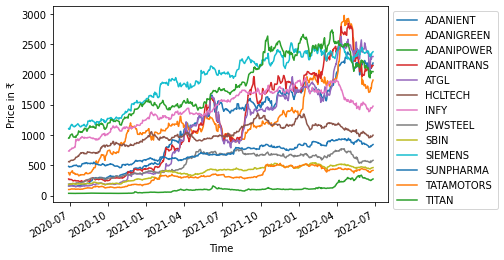

In [32]:
portfolio.plot(x ='Time', y = portfolio.columns[1:], kind = 'line')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Price in \u20B9')
plt.show()

In [33]:
def find_expected_daily_return_sp(weights,portfolio_mu,n):
    '''
    Calculates the expected return for the optimised portfolio
    
    Parameters
    ----------
    weights: np.array
        weights of the selected stocks

    Returns
    -------
    expected_dialy_roi: float
        Expected daily return on inverstment of the optimised portfolio
    
    '''
    expected_daily_roi=0
    for i in range(0,n):
        t = weights[i] * portfolio_mu[i]
        expected_daily_roi+=t
    return expected_daily_roi

In [34]:
from statistics import variance


def find_risk_sp(weights,portfolio_var,n):

    '''Calculates the risk for the optimised portfolio
    
    Parameters
    ----------
    B: float
        budget to be equally invested
    weights: np.array
        weights of the selected stocks

    Returns
    -------
    risk_perc: float
        percetnage risk value of the optimised portfolio with given budget
    '''
    
    var=0
    for i in range(0,n):
        for j in range(0,n):
            t = weights[i]  * weights[j] * portfolio_var[i][j]
            var+=t
    risk = var**0.5
    risk_perc = risk * 100
    return risk_perc

In [35]:
def randomly_weighted_portfolios_with_selected_stocks(nof_portfolio, portfolio_return, portfolio_sigma):
    all_w_list = []
    all_b_list = []
    weight = np.random.random(len(selected_stocks))
    weight /= np.sum(weight)
    all_w_list.append(weight)
    random_portfolios = np.zeros((2,nof_portfolio))
    for i in range(nof_portfolio):
        weight = np.random.random(len(selected_stocks))
        weight /= np.sum(weight)
        all_w_list.append(weight)
        random_portfolios[0,i] = find_expected_daily_return_sp(weight, portfolio_return,len(selected_stocks))*30*100
        random_portfolios[1,i] = find_risk_sp(weight, portfolio_sigma,len(selected_stocks))
    return random_portfolios

In [36]:
def visualize_efficient_frontier_for_selected_stocks():
    simulated_portfolios = randomly_weighted_portfolios_with_selected_stocks(25000,pmu,psigma)
    plt.figure(figsize=(10, 7))
    plt.scatter(simulated_portfolios[1,:],simulated_portfolios[0,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.ylabel('Expected Monthly retrun on investment')
    plt.xlabel('Risk Percentage')
    plt.show()

In [52]:
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns


all_prices=  data.drop(['Time'], axis=1)
sample_cov = risk_models.sample_cov(all_prices, frequency=252)
muc = expected_returns.mean_historical_return(all_prices)


w_classical = [0.0161,0.24485, 0.10312 , 0.23497, 0.01057, 0.20492, 0.13906, 0.04642]
w_classical_all = [0,0.0161,0,0.24485,0.10312,0,0.23497,0,0,0,0,0.01057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.20492,0,0,0,0.13906,0,0,0,0,0,0,0,0,0,0,0.04642,0,0,0,0,0,0,0]
return_based_on_classical_w = find_expected_daily_return_sp(w_classical, muc, 8)*22

risk_based_on_classical_w  = find_risk_sp(w_classical_all, (sample_cov.reset_index(drop = True)).to_numpy(), 49)
print(return_based_on_classical_w,risk_based_on_classical_w)


28.691789345712255 29.73474442716532


In [51]:
quantum_risk = find_risk()
quantum_return = edroi * 22 *100
print(quantum_risk,quantum_return)

0.01636898690570689 6.7450036533601185


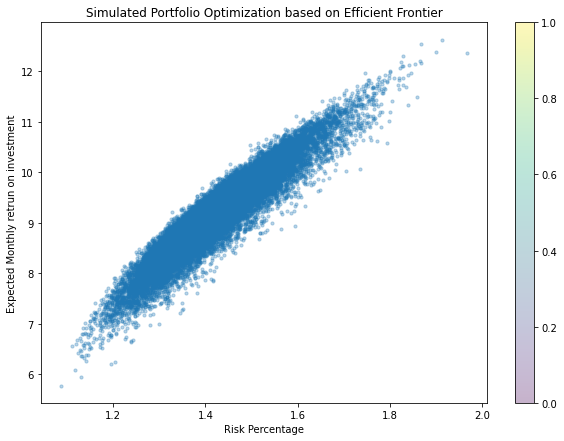

In [37]:
visualize_efficient_frontier_for_selected_stocks()